In [1]:
# Debug RF

from ml4paleo.segmentation import RandomForest3DSegmenter
import skimage.feature
from functools import partial
import pathlib
from config import CONFIG
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

In [2]:
job_name = "6662F2"


path_to_training = pathlib.Path(CONFIG.training_directory) / job_name 
imgs_fn = sorted(path_to_training.glob(CONFIG.training_img_prefix + "*"))
segs_fn = sorted(path_to_training.glob(CONFIG.training_seg_prefix + "*"))

In [3]:
Xs = [
    # Get greyscale images
    np.array(Image.open(fn).convert("L"))
    for fn in imgs_fn[-5:]
]

Ys = [
    # Get just the red channel
    np.array(Image.open(fn).convert("RGB"))[:,:,0]
    for fn in segs_fn[-5:]
]

In [4]:
feature_fn = partial(
    skimage.feature.multiscale_basic_features, 
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=0.5,
    sigma_max=16,
)


In [5]:
model = RandomForest3DSegmenter(
    rf_kwargs={
    # "n_estimators": 50, "max_depth": 3, "n_jobs": -1
    },
    features_fn=feature_fn,
)
model._training_subsample = 100
X = np.stack(Xs)
# vmax = X.mean() + 2 * X.std()
# vmin = X.mean() - 2 * X.std()
# # Remap to full dynamic range
# X = ((X - vmin) / (vmax - vmin)) * 255
# X = X.clip(0, 255).astype(np.uint8)
Y = np.stack(Ys)

model.fit(X, Y)


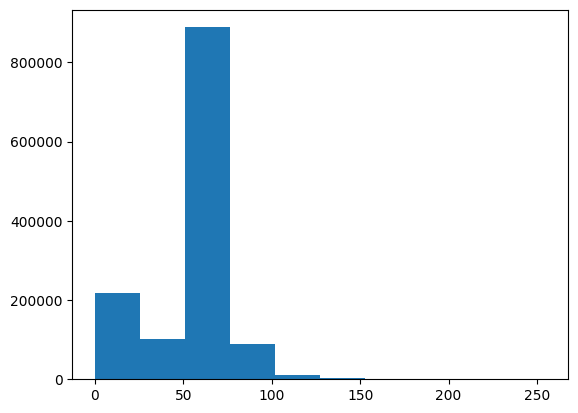

In [6]:
plt.hist(X.flatten())
plt.show()

In [7]:
model.segment(np.expand_dims(Xs[0], axis=-1)).max()

255

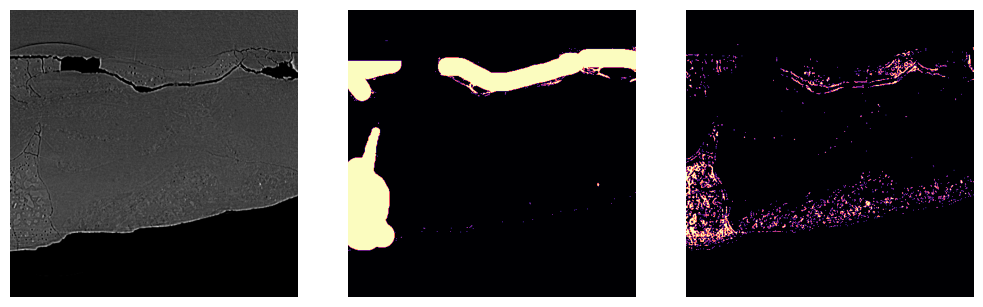

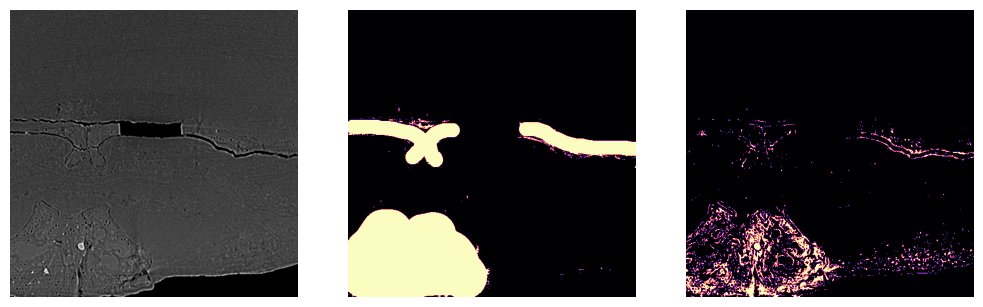

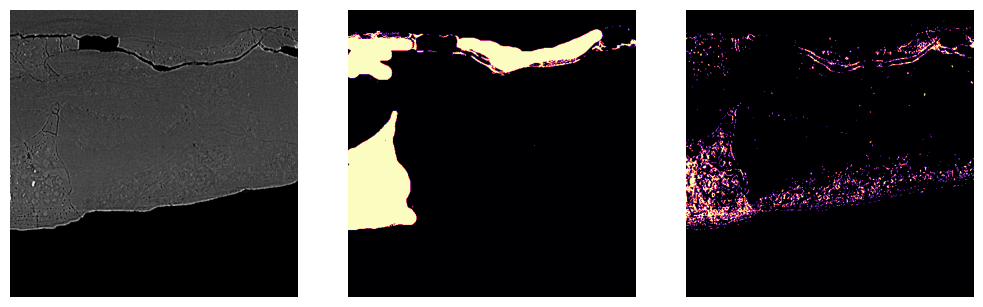

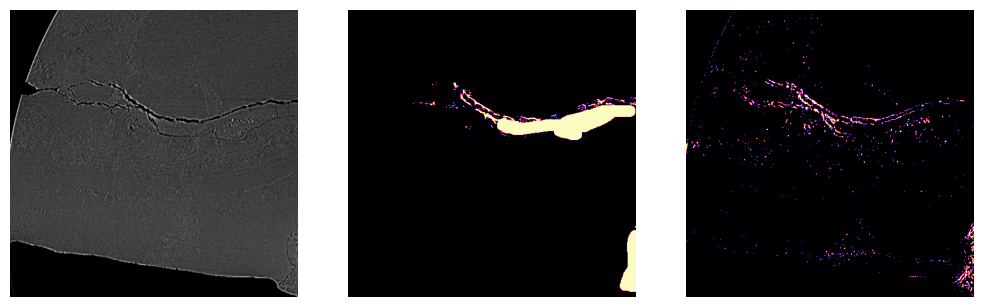

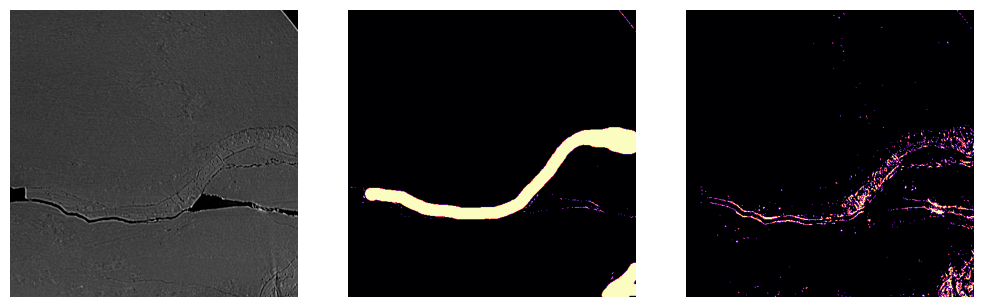

In [8]:
# Draw three subplots:
# Original image
# True Segmentation
# Predicted segmentation
for i in range(5):
    plt.subplots(1, 3, figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(Xs[i], cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(Ys[i], cmap="magma")
    plt.tight_layout()
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(255*(model.segment(np.expand_dims(Xs[i], axis=-1)).astype(np.uint8)), cmap="magma")
    plt.tight_layout()
    plt.axis("off")
